## References
* [Kaggle, Coronavirus (COVID-19) Visualization & Prediction](https://www.kaggle.com/code/therealcyberlord/coronavirus-covid-19-visualization-prediction/notebook#US-Medical-Data-on-Testing)  </br>

* [Kaggle, COVID-19 - Analysis, Visualization & Comparisons](https://www.kaggle.com/code/imdevskp/covid-19-analysis-visualization-comparisons#Date-vs) </br>
* [Worldmeters Coronavirus](https://www.worldometers.info/coronavirus/#countries) </br>
* [Johns Hopkins Center for Systems Science and Engineering COVID-19 GitHub](https://github.com/CSSEGISandData/COVID-19) </br>
* [Johns Hopkins Coronavirus Resouce Center](https://coronavirus.jhu.edu/map.html) </br> 
* [World Population](https://worldpopulationreview.com/countries)</br>

# Libraries 

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import pandas as pd
import random 
import math 
import time 
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import datetime
import operator 
plt.style.use('seaborn-poster')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings 
warnings.filterwarnings('ignore')

# interactive visualization
import plotly.express as px
import plotly.graph_objs as go
# import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Data

Query Countries

In [211]:
countries = ['Taiwan*', 'US', 'Hong Kong', 'Vietnam', 'Singapore', 'India', 'New Zealand', ]
# countries = ['US']

Import Data

In [212]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
population_df = pd.read_csv('population.csv')

In [213]:
recoveries_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/27/22,3/28/22,3/29/22,3/30/22,3/31/22,4/1/22,4/2/22,4/3/22,4/4/22,4/5/22
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
population_df

,Rank,name,pop2022,pop2021,GrowthRate,area,Density
0,203,Monaco,39.783,39.511,1.0069,2,19891.5000
1,115,Singapore,5943.546,5896.686,1.0079,710,8371.1915
2,105,Hong Kong,7604.299,7552.810,1.0068,1104,6887.9520
3,156,Bahrain,1783.983,1748.296,1.0204,765,2332.0039
4,176,Maldives,540.985,543.617,0.9952,300,1803.2833
...,...,...,...,...,...,...,...
204,183,Iceland,345.393,343.353,1.0059,103000,3.3533
205,146,Namibia,2633.874,2587.344,1.0180,825615,3.1902
206,173,Western Sahara,626.161,611.875,1.0233,266000,2.3540
207,137,Mongolia,3378.078,3329.289,1.0147,1564110,2.1597


Process Data

In [215]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i] - data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i < window_size:
            moving_average.append(np.mean(data[ : i]))
        else:
            moving_average.append(np.mean(data[i - window_size : i]))
    return moving_average 

window = 7


In [216]:
# ideally should be able to set start date and end date

# Get dates 
offsetDays = 100
cols = confirmed_df.keys()
date = np.array(cols)[4:-1]

for country in countries: 
    # get population 
    population = population_df[population_df['name']==country]['pop2022']
    population = int(population)/1e3
    print( population )

    
    # Search from 'Country/Region' or 'Province/State'
    searchFrom = 'Country/Region'
    aRow = confirmed_df[confirmed_df[searchFrom]==country]
    if aRow.shape[0] == 0:
        searchFrom = 'Province/State'

    # Get data
    totalConfirmedRows = confirmed_df[confirmed_df[searchFrom]==country]
    totalDeathsRows = deaths_df[deaths_df[searchFrom]==country]

    totalConfirmed = []
    totalDeaths = []
    # skip the first 4 columns. they are state, country, lat, and long 
    for i in range(4, len(date)+4):
        ConfirmedVal = sum(np.array(totalConfirmedRows)[:,i])
        DeathVal = sum(np.array(totalDeathsRows)[:,i])
        totalConfirmed.append(ConfirmedVal)
        totalDeaths.append(DeathVal)

    totalMortality = []
    for i in range(len(totalConfirmed)):
        if totalConfirmed[i] == 0:
            totalMortality.append(0)
        else: 
            totalMortality.append(totalDeaths[i]/totalConfirmed[i])

    # Create DataFrame 
    new_df = pd.DataFrame( 
            {   'Date': date[offsetDays:-1], 
                'Total Confirmed': moving_average(totalConfirmed, window)[offsetDays:-1], 
                'Daily Confirmed': moving_average(daily_increase(totalConfirmed), window)[offsetDays:-1], 
                'Total Confirmed Per 1M Population' : np.array(moving_average(totalConfirmed, window)[offsetDays:-1])/population, 
                'Total Deaths': moving_average(totalDeaths, window)[offsetDays:-1],
                'Daily Deaths': moving_average(daily_increase(totalDeaths), window)[offsetDays:-1], 
                'Total Deaths Per 1M Population' : np.array(moving_average(totalDeaths, window)[offsetDays:-1])/population, 
                'Total Mortality': moving_average(totalMortality, window)[offsetDays:-1],
                # 'Daily Mortality': daily_increase(totalMortality), 
            } 
        )


    # Save DataFrame 
    country = country.split('*')
    country = ''.join(country)
    new_df.to_csv(country+'.csv')

    print('Processing: {}'.format(country))
    # print(new_df.tail())




23.888
Processing: Taiwan
334.805
Processing: US
7.604
Processing: Hong Kong
98.953
Processing: Vietnam
5.943
Processing: Singapore
1406.631
Processing: India
4.898
Processing: New Zealand


# Visualization

In [217]:
def ploty_line(col, log_plot=False):
    df2 = pd.DataFrame()
    for country in countries:
        # read data 
        country = country.split('*')
        country = ''.join(country)
        df = pd.read_csv(country+'.csv')
        # add another column 
        df['Country'] = [country for _ in range(df['Date'].shape[0])]
        df2 = df2.append(df, ignore_index=True)


    df2.rename(columns = {'Country':' '}, inplace = True)
    fig = px.scatter(
        df2, x='Date', y=col, color=' ',
        height=550, width=800, title=col, log_y=log_plot, 
        # color_discrete_sequence = px.colors.cyclical.mygbm 
    )
    fig.update_layout(showlegend=True)     
    fig.show()
    # fig.write_image("fig.png")
    # fig.to_image(format="png", engine="orca")


In [218]:
ploty_line('Total Confirmed', log_plot=True)

In [219]:
# ,Date,Total Confirmed,Daily Confirmed,Total Deaths,Daily Deaths,Total Mortality
ploty_line('Daily Confirmed', log_plot=True)

In [220]:
ploty_line('Total Confirmed Per 1M Population', log_plot=True)

In [221]:
ploty_line('Total Deaths', log_plot=True)

In [222]:
ploty_line('Daily Deaths', log_plot=True)

In [223]:
ploty_line('Total Mortality', log_plot=True)


In [224]:
ploty_line('Total Deaths Per 1M Population', log_plot=True)

# Static image and save image 

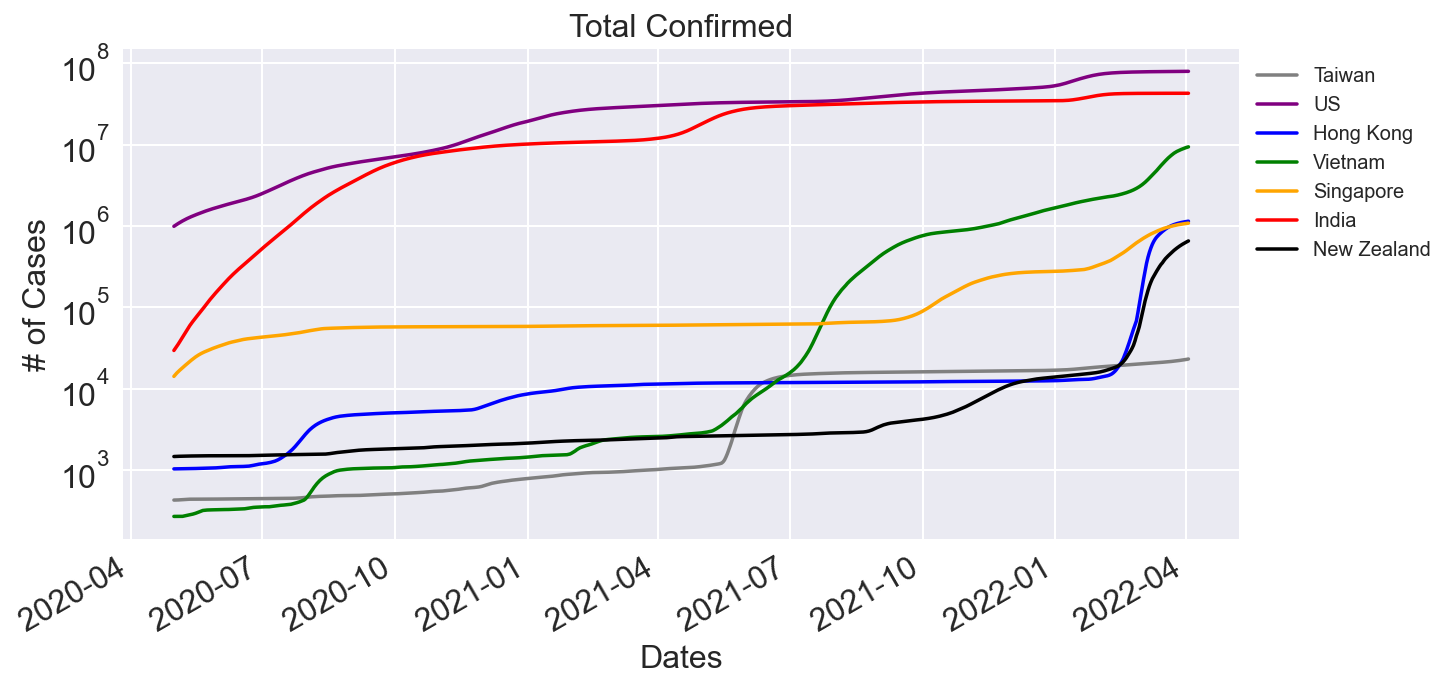

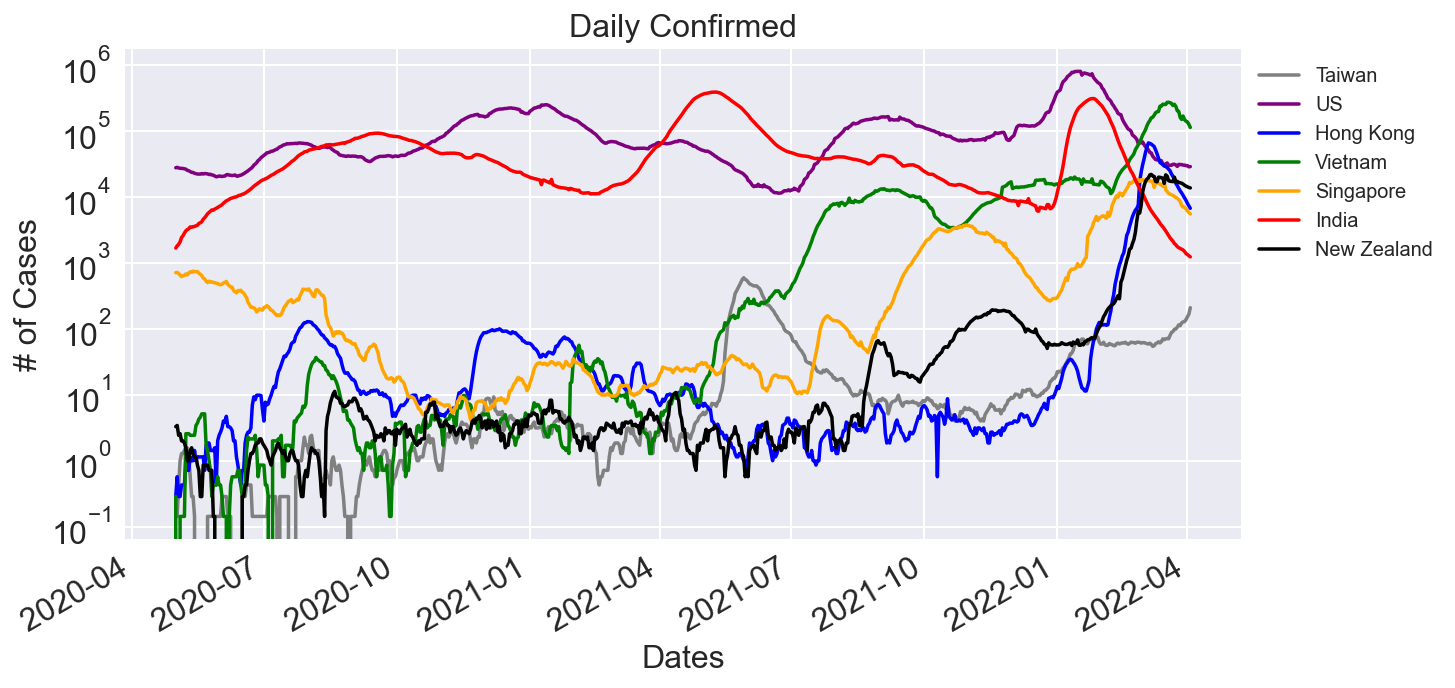

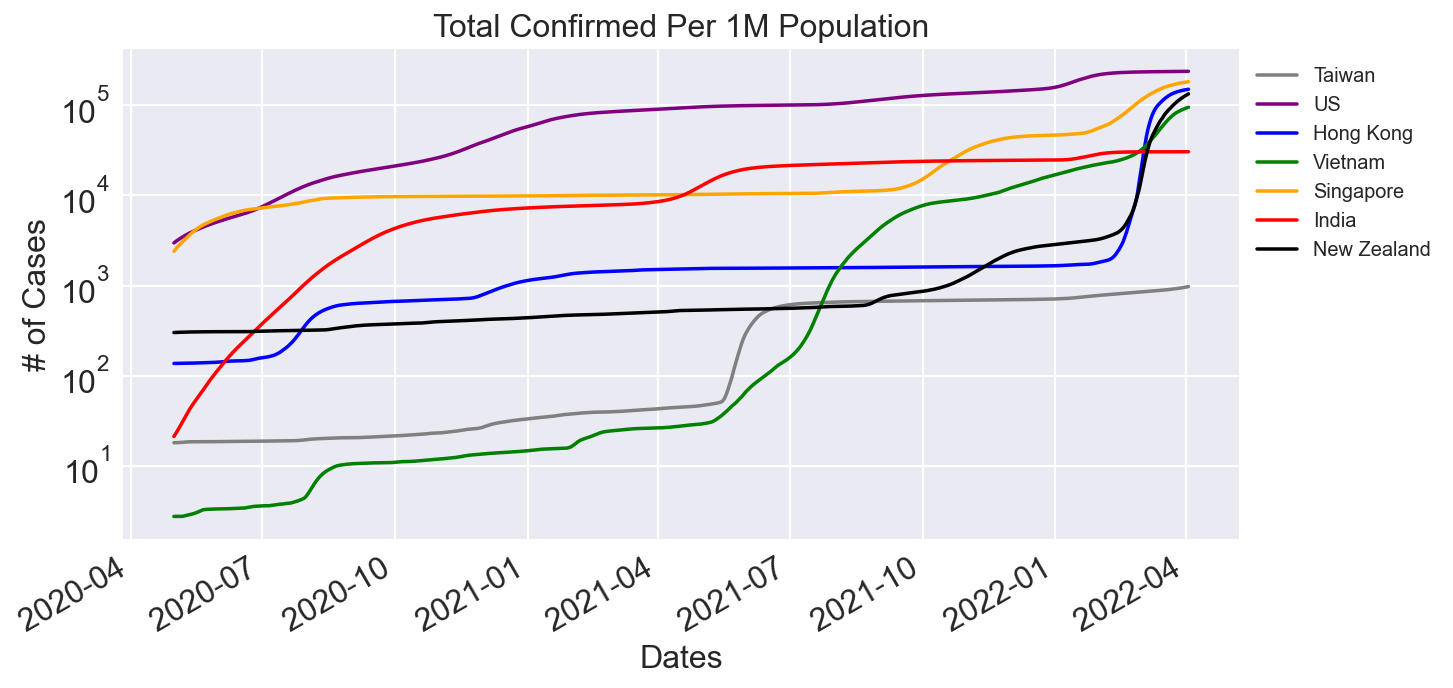

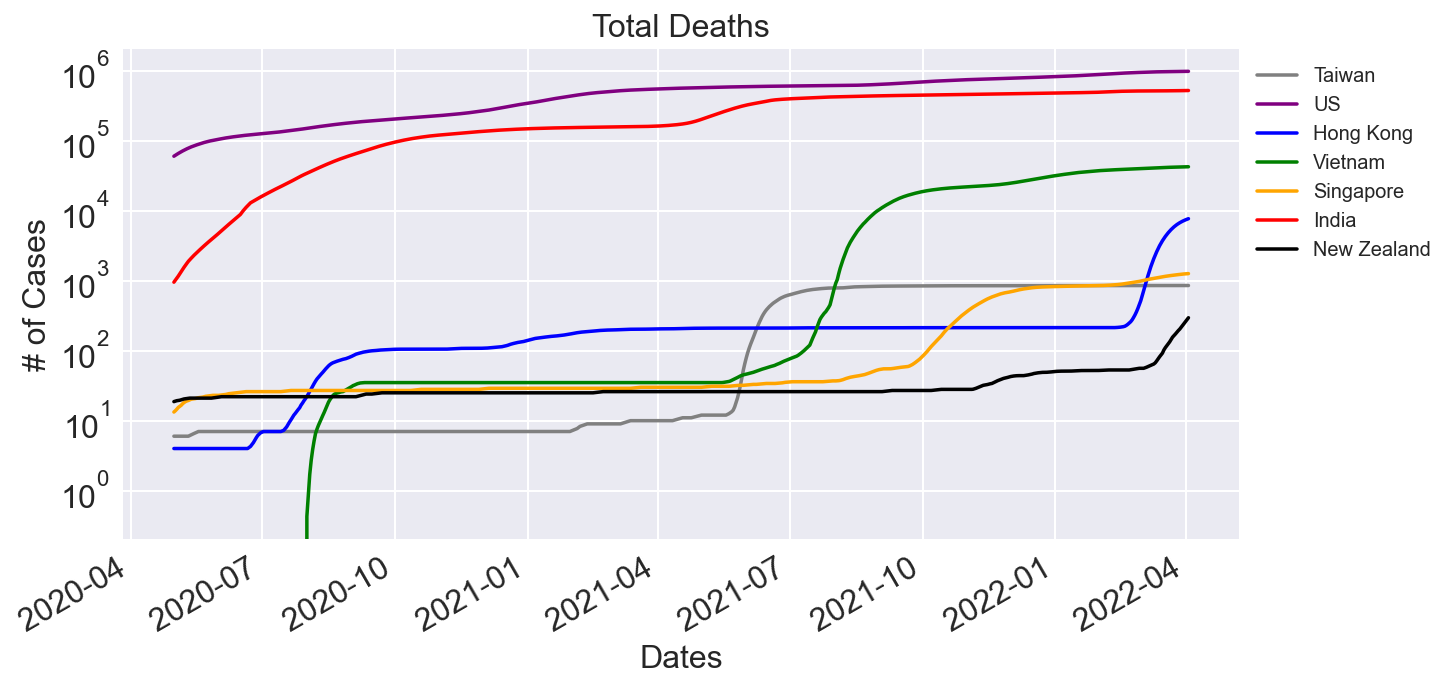

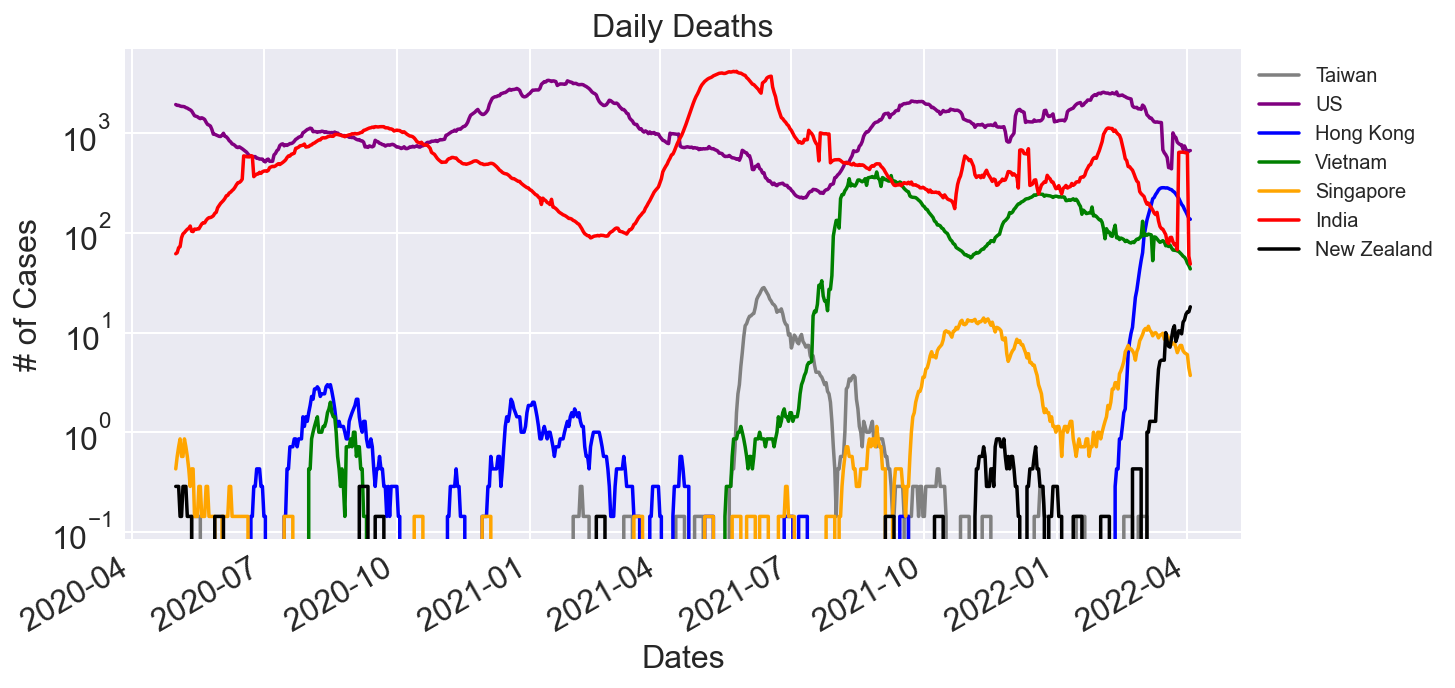

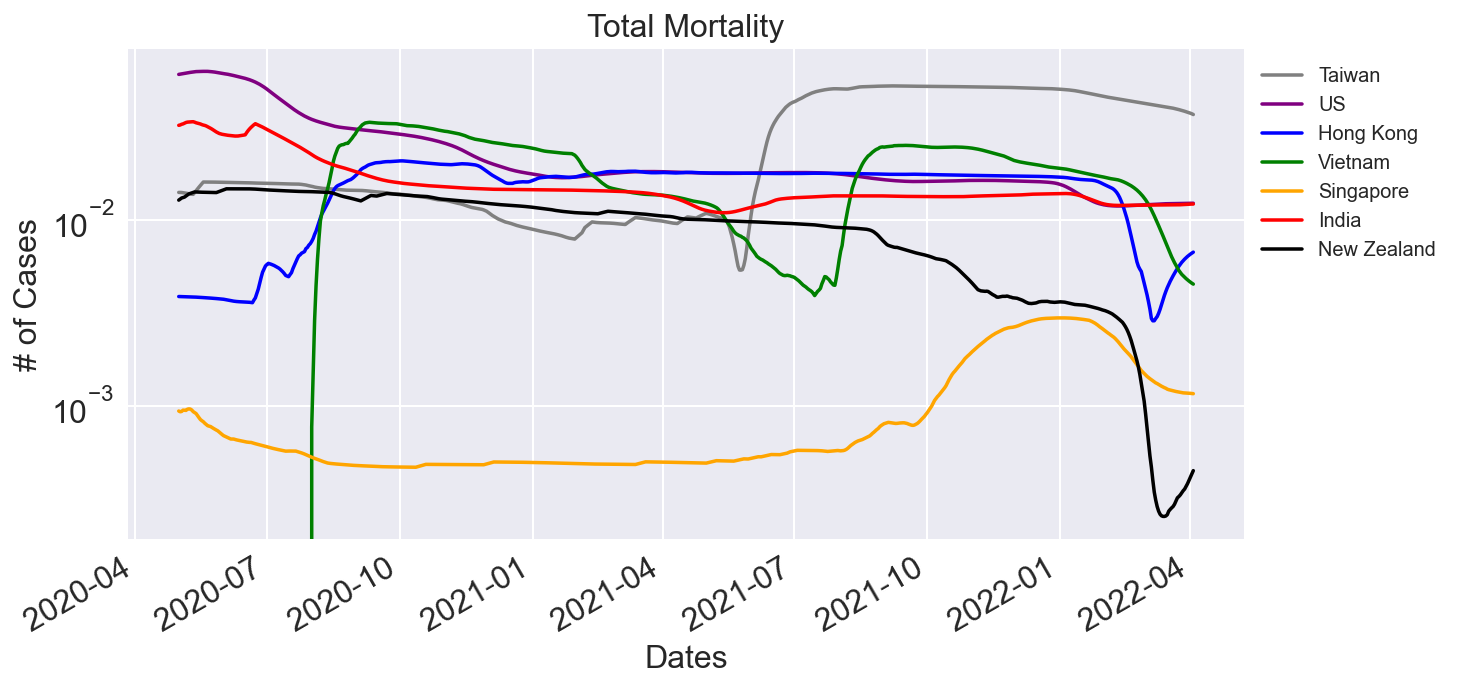

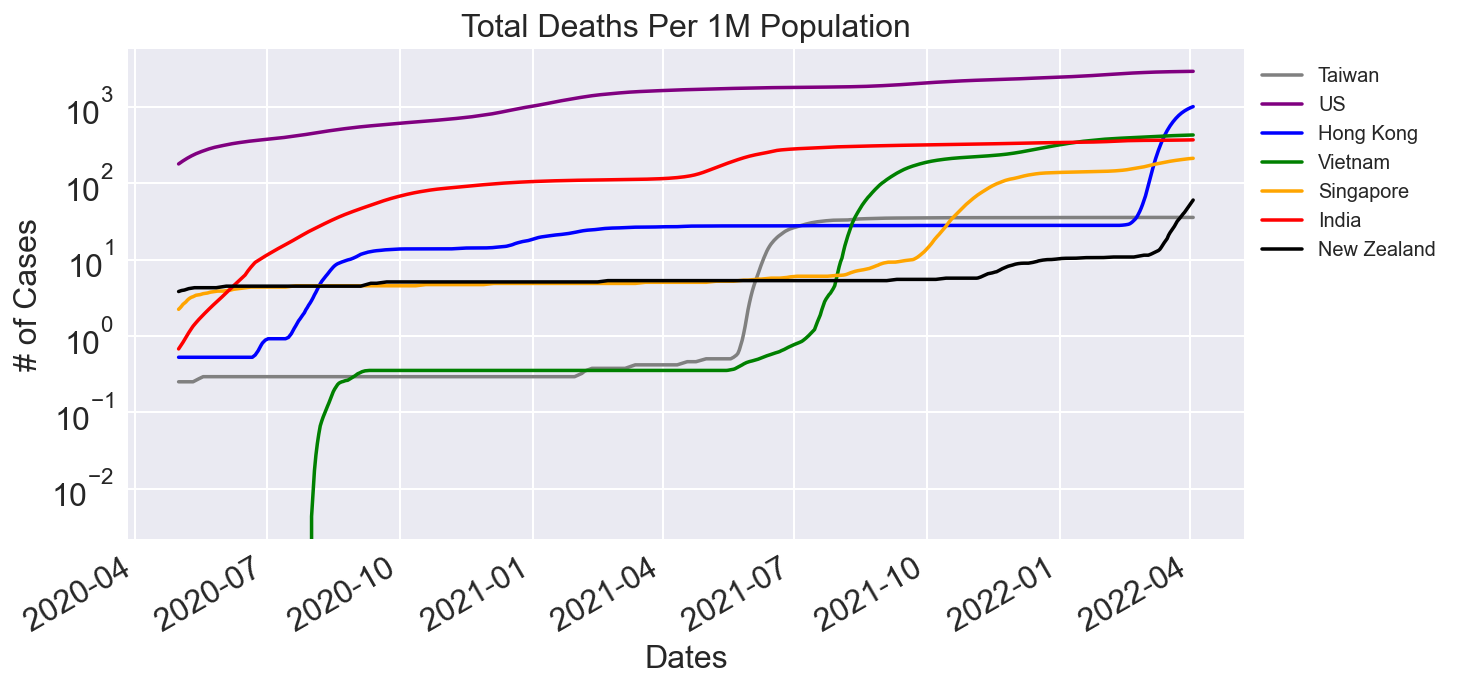

In [412]:
def plot_line(col):
    plt.figure(figsize=(10, 5))
    plt.style.use('seaborn')
    cmap = ['Grey', 'Purple', 'Blue', 'Green', 'Orange', 'Red',
            'black', 'magneta', 'navy', 'darkgreen', 'darkorange', 'darkRed'
            ]
    for i, country in enumerate(countries):
        # read data 
        country = country.split('*')
        country = ''.join(country)
        df = pd.read_csv(country+'.csv')


        # Convert string to datetime for pandas to recognise 
        df['Date'] = pd.to_datetime(df['Date'])

        plt.plot(df['Date'], df[col], color=cmap[i], linestyle='solid', label=country)

    plt.yscale("log")
    plt.gcf().autofmt_xdate()
    plt.title(col, size = 16)
    # plt.legend([country], prop={'size' : 16})
    # plt.legend(prop={'size' : 16, 'loc': 'best'})
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1, prop={'size' : 16})
    plt.xlabel('Dates', size=16)
    plt.ylabel('# of Cases', size=16)
    plt.xticks(size=16)
    plt.yticks(size=16)

    plt.savefig(col+'.png')

plot_line('Total Confirmed')
plot_line('Daily Confirmed')
plot_line('Total Confirmed Per 1M Population')
plot_line('Total Deaths')
plot_line('Daily Deaths')
plot_line('Total Mortality')
plot_line('Total Deaths Per 1M Population')



# [Matplotlib Tutorial (Part 10): Subplots](https://www.youtube.com/watch?v=XFZRVnP-MTU&list=PL-osiE80TeTvipOqomVEeZ1HRrcEvtZB_&index=10)

import data

In [239]:
country = 'Taiwan'
df = pd.read_csv(country+'.csv')
df



,Unnamed: 0,Date,Total Confirmed,Daily Confirmed,Total Confirmed Per 1M Population,Total Deaths,Daily Deaths,Total Deaths Per 1M Population,Total Mortality
0,0,5/1/20,428.857143,0.285714,17.952827,6.0,0.0,0.251172,0.013991
1,1,5/2/20,429.000000,0.142857,17.958808,6.0,0.0,0.251172,0.013986
2,2,5/3/20,429.428571,0.428571,17.976749,6.0,0.0,0.251172,0.013972
3,3,5/4/20,430.428571,1.000000,18.018611,6.0,0.0,0.251172,0.013940
4,4,5/5/20,431.714286,1.285714,18.072433,6.0,0.0,0.251172,0.013899
...,...,...,...,...,...,...,...,...,...
698,698,3/30/22,22600.142857,128.714286,946.087695,853.0,0.0,35.708305,0.037749
699,699,3/31/22,22738.285714,138.142857,951.870634,853.0,0.0,35.708305,0.037519
700,700,4/1/22,22890.714286,152.428571,958.251603,853.0,0.0,35.708305,0.037270
701,701,4/2/22,23057.285714,166.571429,965.224620,853.0,0.0,35.708305,0.037003


Use matplotlib.pyplot

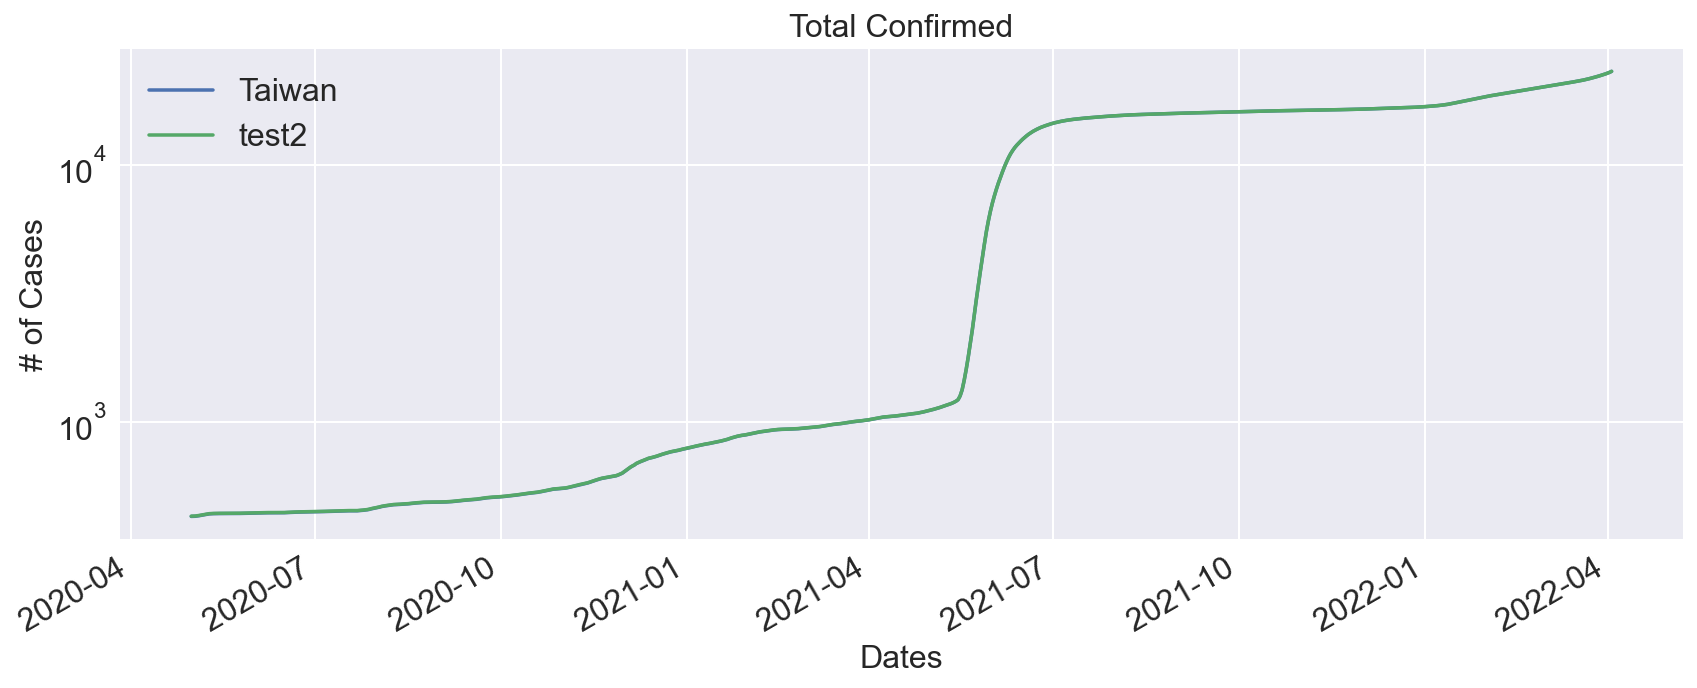

In [315]:
col = 'Total Confirmed'

plt.figure(figsize=(14, 5))
plt.style.use('seaborn')
# Convert string to datetime for pandas to recognise 
df['Date'] = pd.to_datetime(df['Date'])

plt.plot(df['Date'], df[col], linestyle='solid', label=country)
plt.plot(df['Date'], np.array(df[col])+1, linestyle='solid', label='test2')
plt.yscale("log")

plt.gcf().autofmt_xdate()
plt.title(col, size = 16)
# plt.legend([country], prop={'size' : 16})
plt.legend(prop={'size' : 16})
plt.xlabel('Dates', size=16)
plt.ylabel('# of Cases', size=16)
plt.xticks(size=16)
plt.yticks(size=16)

plt.savefig('fig.png')


Use fig, ax, from subplots

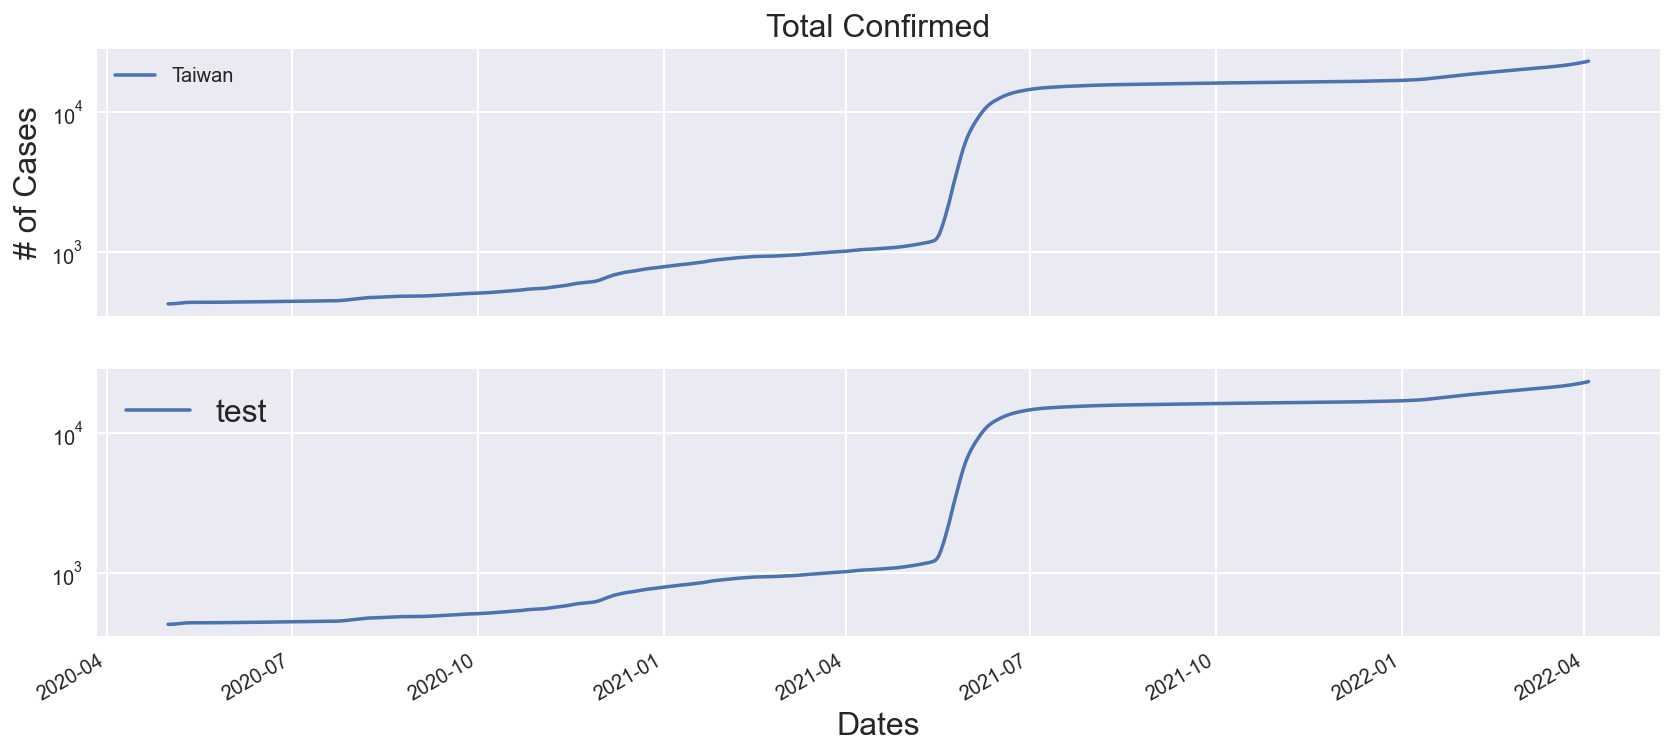

In [373]:
col = 'Total Confirmed'
# Convert string to datetime for pandas to recognise 
df['Date'] = pd.to_datetime(df['Date'])
#
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=2, ncols=1)

#
ax[0].plot(df['Date'], df[col], linestyle='solid', label=country)
ax[0].set_yscale("log")
ax[0].set_title(col, size = 16)
ax[0].legend()
ax[0].set_ylabel('# of Cases', size=16)
#
ax[1].plot(df['Date'], np.array(df[col])+1, linestyle='solid', label='test')
ax[1].set_yscale("log")
ax[1].legend(prop={'size' : 16})
ax[1].set_xlabel('Dates', size=16)
#

# Will have multiple ax. But still only one fig 
fig.set_size_inches(14, 6)
fig.autofmt_xdate()
fig.savefig('TestAxFig.png')

# not easy to use 
#ax[0].minorticks_on()
# ax[1].set_yticks(size=16)



Modifing the xticks 

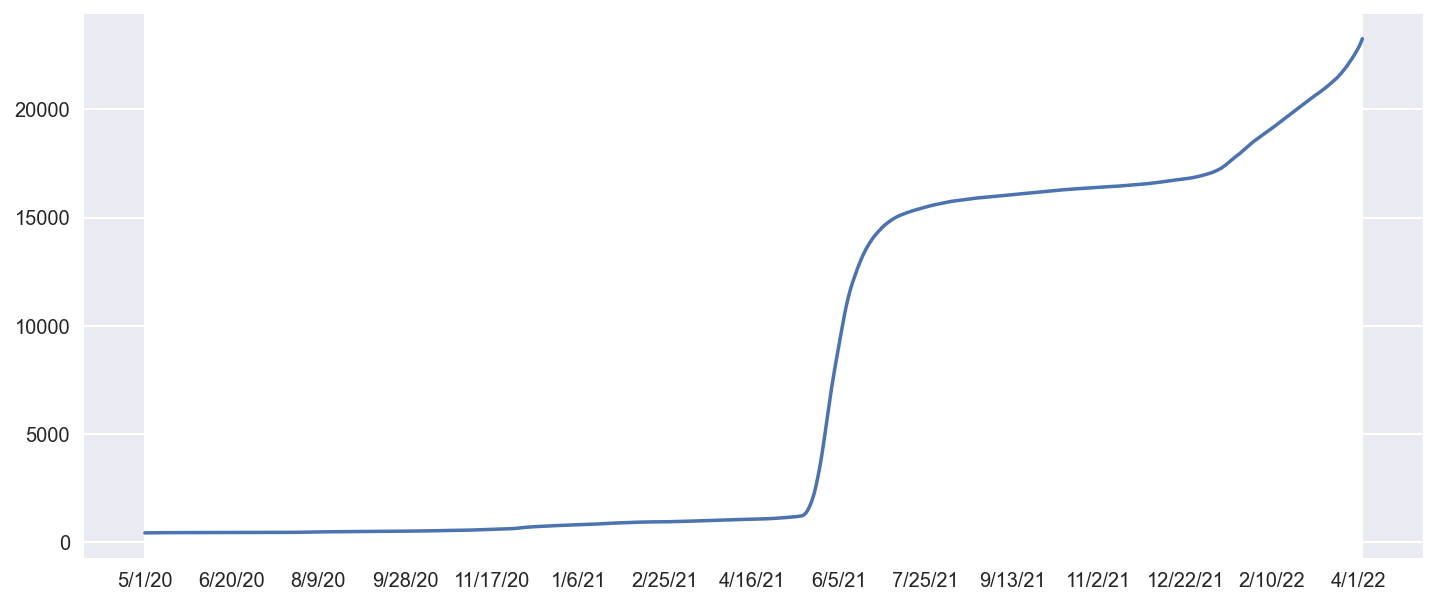

In [391]:
country = 'Taiwan'
df = pd.read_csv(country+'.csv')

fig, ax = plt.subplots()

# plt.figure(figsize=(16, 4))
# plt.locator_params(axis='x', nbins=6)
# plt.locator_params(axis='y', nbins=10)
ax.plot(df['Date'], df['Total Confirmed'])
ax.axes.grid(True)
fig.set_size_inches(12, 5)

every_nth = 50
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

